<a href="https://colab.research.google.com/github/Akkamaraj/ai-mental-health-support/blob/main/Airtraffic_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
df= pd.read_csv("/content/generated_air_traffic_detailed.csv", header=0) # set header=1 for naming purposes
df

,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,202003,01-01-2019,Delta Air Lines,DL,United,AA,International,North America,Enplaned,Full Fare,T1,D,85,31-12-2023,01-01-2024
1,202249,02-01-2019,American Airlines,WN,American,WN,International,Asia,Thru / Transfer,Low Fare,T3,E,89,31-12-2023,01-01-2024
2,202171,03-01-2019,Southwest Airlines,DL,American,UA,Domestic,Latin America,Enplaned,Low Fare,T2,C,91,31-12-2023,01-01-2024
3,202007,04-01-2019,Southwest Airlines,UA,United,WN,Domestic,Europe,Thru / Transfer,Low Fare,T4,C,113,31-12-2023,01-01-2024
4,201972,05-01-2019,Southwest Airlines,AA,American,AA,Domestic,Latin America,Deplaned,Low Fare,T2,D,83,31-12-2023,01-01-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,202192,22-09-2021,American Airlines,UA,United,DL,International,North America,Thru / Transfer,Full Fare,T1,A,95,31-12-2023,01-01-2024
996,202157,23-09-2021,Southwest Airlines,DL,United,WN,Domestic,Asia,Deplaned,Low Fare,T1,D,81,31-12-2023,01-01-2024
997,201908,24-09-2021,Southwest Airlines,WN,Southwest,UA,Domestic,North America,Enplaned,Full Fare,T2,B,102,31-12-2023,01-01-2024
998,202013,25-09-2021,American Airlines,UA,American,AA,Domestic,Europe,Deplaned,Full Fare,T1,B,106,31-12-2023,01-01-2024


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              1000 non-null   int64 
 1   Activity Period Start Date   1000 non-null   object
 2   Operating Airline            1000 non-null   object
 3   Operating Airline IATA Code  1000 non-null   object
 4   Published Airline            1000 non-null   object
 5   Published Airline IATA Code  1000 non-null   object
 6   GEO Summary                  1000 non-null   object
 7   GEO Region                   1000 non-null   object
 8   Activity Type Code           1000 non-null   object
 9   Price Category Code          1000 non-null   object
 10  Terminal                     1000 non-null   object
 11  Boarding Area                1000 non-null   object
 12  Passenger Count              1000 non-null   int64 
 13  data_as_of                   1000 

In [4]:
df.describe()

,Activity Period,Passenger Count
count,1000.000000,1000.000000
mean,202109.167000,99.976000
std,117.697348,10.018972
min,201901.000000,65.000000
25%,202012.000000,94.000000
50%,202110.000000,100.000000
75%,202211.000000,107.000000
max,202311.000000,138.000000


In [5]:
df.head()

,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,202003,01-01-2019,Delta Air Lines,DL,United,AA,International,North America,Enplaned,Full Fare,T1,D,85,31-12-2023,01-01-2024
1,202249,02-01-2019,American Airlines,WN,American,WN,International,Asia,Thru / Transfer,Low Fare,T3,E,89,31-12-2023,01-01-2024
2,202171,03-01-2019,Southwest Airlines,DL,American,UA,Domestic,Latin America,Enplaned,Low Fare,T2,C,91,31-12-2023,01-01-2024
3,202007,04-01-2019,Southwest Airlines,UA,United,WN,Domestic,Europe,Thru / Transfer,Low Fare,T4,C,113,31-12-2023,01-01-2024
4,201972,05-01-2019,Southwest Airlines,AA,American,AA,Domestic,Latin America,Deplaned,Low Fare,T2,D,83,31-12-2023,01-01-2024


In [6]:
#  Step 3: Parse date columns and set index
df['data_as_of'] = pd.to_datetime(df['data_as_of'])
df['data_loaded_at'] = pd.to_datetime(df['data_loaded_at'])

# Set 'data_as_of' as the index
df.set_index('data_as_of', inplace=True)



In [7]:
df

,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_loaded_at
data_as_of,,,,,,,,,,,,,,
2023-12-31,202003,01-01-2019,Delta Air Lines,DL,United,AA,International,North America,Enplaned,Full Fare,T1,D,85,2024-01-01
2023-12-31,202249,02-01-2019,American Airlines,WN,American,WN,International,Asia,Thru / Transfer,Low Fare,T3,E,89,2024-01-01
2023-12-31,202171,03-01-2019,Southwest Airlines,DL,American,UA,Domestic,Latin America,Enplaned,Low Fare,T2,C,91,2024-01-01
2023-12-31,202007,04-01-2019,Southwest Airlines,UA,United,WN,Domestic,Europe,Thru / Transfer,Low Fare,T4,C,113,2024-01-01
2023-12-31,201972,05-01-2019,Southwest Airlines,AA,American,AA,Domestic,Latin America,Deplaned,Low Fare,T2,D,83,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,202192,22-09-2021,American Airlines,UA,United,DL,International,North America,Thru / Transfer,Full Fare,T1,A,95,2024-01-01
2023-12-31,202157,23-09-2021,Southwest Airlines,DL,United,WN,Domestic,Asia,Deplaned,Low Fare,T1,D,81,2024-01-01
2023-12-31,201908,24-09-2021,Southwest Airlines,WN,Southwest,UA,Domestic,North America,Enplaned,Full Fare,T2,B,102,2024-01-01


In [8]:
#  Step 4: Rename for simplicity (assuming column with traffic is 'Passengers')
df.rename(columns={df.columns[0]: 'Passengers'}, inplace=True)


In [9]:
df

,Passengers,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_loaded_at
data_as_of,,,,,,,,,,,,,,
2023-12-31,202003,01-01-2019,Delta Air Lines,DL,United,AA,International,North America,Enplaned,Full Fare,T1,D,85,2024-01-01
2023-12-31,202249,02-01-2019,American Airlines,WN,American,WN,International,Asia,Thru / Transfer,Low Fare,T3,E,89,2024-01-01
2023-12-31,202171,03-01-2019,Southwest Airlines,DL,American,UA,Domestic,Latin America,Enplaned,Low Fare,T2,C,91,2024-01-01
2023-12-31,202007,04-01-2019,Southwest Airlines,UA,United,WN,Domestic,Europe,Thru / Transfer,Low Fare,T4,C,113,2024-01-01
2023-12-31,201972,05-01-2019,Southwest Airlines,AA,American,AA,Domestic,Latin America,Deplaned,Low Fare,T2,D,83,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,202192,22-09-2021,American Airlines,UA,United,DL,International,North America,Thru / Transfer,Full Fare,T1,A,95,2024-01-01
2023-12-31,202157,23-09-2021,Southwest Airlines,DL,United,WN,Domestic,Asia,Deplaned,Low Fare,T1,D,81,2024-01-01
2023-12-31,201908,24-09-2021,Southwest Airlines,WN,Southwest,UA,Domestic,North America,Enplaned,Full Fare,T2,B,102,2024-01-01


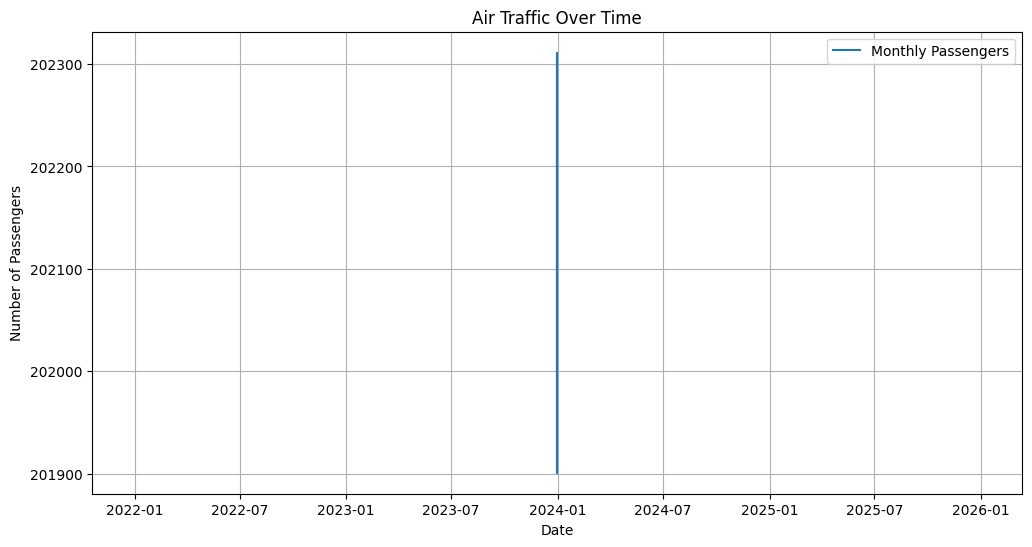

In [10]:
#  Step 5: Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df['Passengers'], label='Monthly Passengers')
plt.title("Air Traffic Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.grid()
plt.legend()
plt.show()

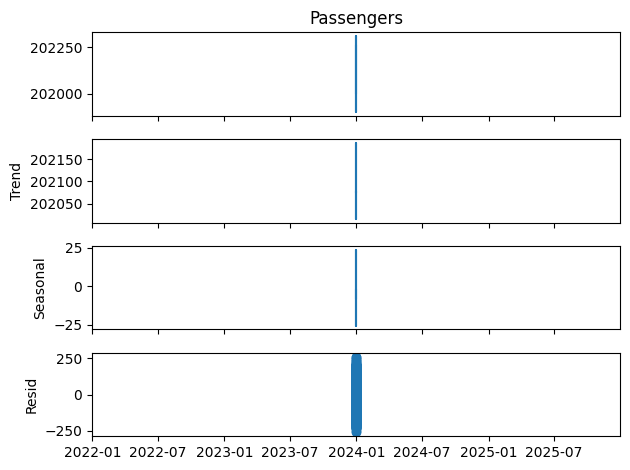

In [11]:
#  Step 6: Decompose the time series
decompose_result = seasonal_decompose(df['Passengers'], model='additive', period=12)
decompose_result.plot()
plt.tight_layout()
plt.show()

In [12]:
#  Step 7: Train-test split
train = df.iloc[:-12]
test = df.iloc[-12:]

In [13]:
#  Step 8: Fit SARIMA model
model = SARIMAX(train['Passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

In [14]:
# Forecast
forecast = model_fit.forecast(steps=12)

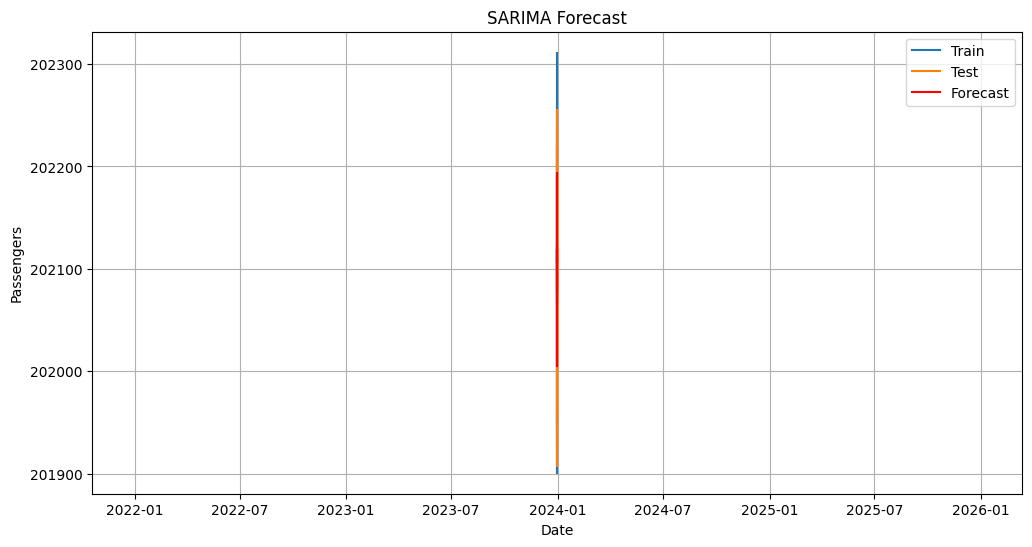

In [15]:
#  Step 9: Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test.index, test['Passengers'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Evaluation
mae = mean_absolute_error(test['Passengers'], forecast)

# Calculate MSE first, then take the square root for RMSE
mse = mean_squared_error(test['Passengers'], forecast)
rmse = np.sqrt(mse) # Manually calculate RMSE

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 156.04
RMSE: 165.70


In [17]:
#  Step 11: Forecast into the future (e.g., next 24 months)
final_model = SARIMAX(df['Passengers'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
future_forecast = final_model.forecast(steps=24)

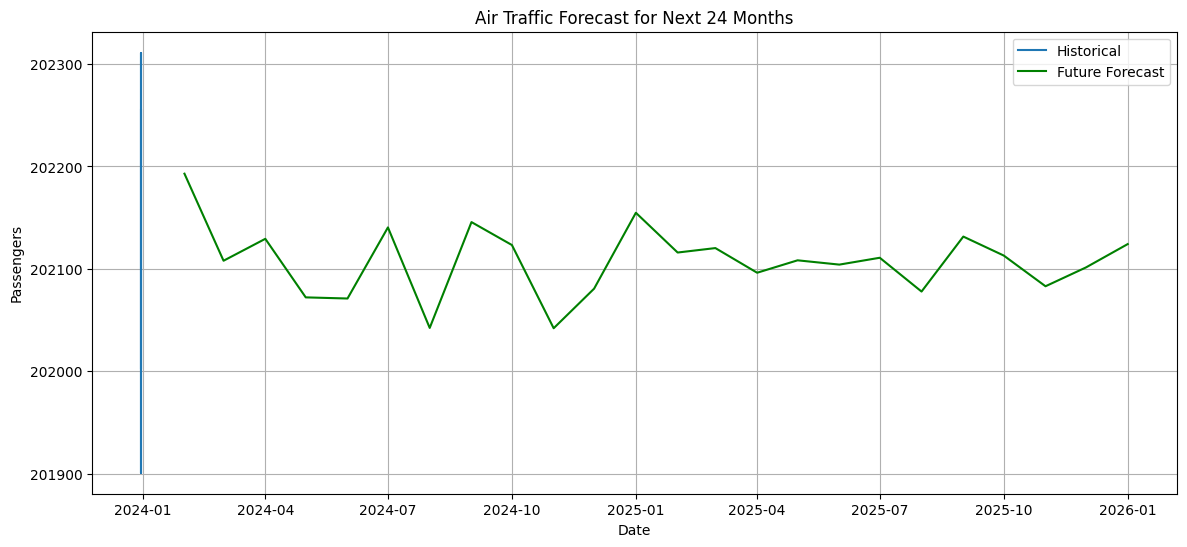

In [18]:
#  Step 12: Plot future forecast
plt.figure(figsize=(14,6))
plt.plot(df['Passengers'], label='Historical')
future_dates = pd.date_range(start=df.index[-1]+pd.DateOffset(months=1), periods=24, freq='MS')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='green')
plt.title("Air Traffic Forecast for Next 24 Months")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [20]:
# Step 2: Normalize the data
scaler = MinMaxScaler()

# Select only the 'Passengers' column for scaling
# Convert the Series to a DataFrame with a single column as fit_transform expects a 2D array
scaled_data = scaler.fit_transform(df[['Passengers']])

# Now scaled_data contains the normalized 'Passengers' data
# You can optionally add this scaled data back to your original dataframe if needed,
# or proceed with building your model using this scaled data.

In [21]:
# Step 3: Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [22]:
SEQ_LEN = 12  # past 12 months to predict next month
X, y = create_sequences(scaled_data, SEQ_LEN)

In [23]:
# Step 4: Split into train and test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [24]:
# Step 5: Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LEN, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
# Step 6: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2282
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0825
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0826
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0819
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0824
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0812
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0866
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0812
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0802
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0874


In [26]:
# Step 7: Predict
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


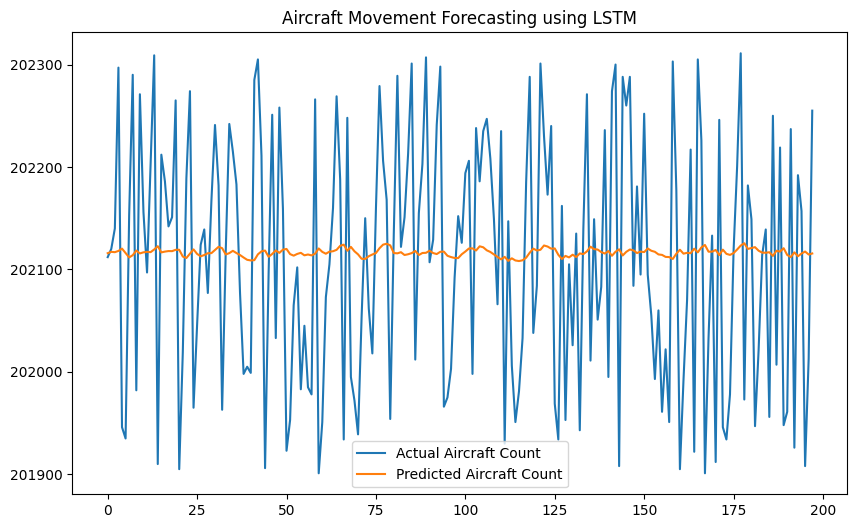

In [27]:
# Step 8: Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Aircraft Count')
plt.plot(predicted, label='Predicted Aircraft Count')
plt.legend()
plt.title("Aircraft Movement Forecasting using LSTM")
plt.show()